In [1]:
import numpy as np
import pandas as pd
import json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os

In [2]:
'''
Read in saved dataset to use to feed into the model.
Further pre-processing still needs to be done on the state vectors
'''

data_df = pd.read_pickle('/home/amans/Development/scott/nfl-big-data-bowl-2022/clean_dir/ball_carrier_dataset.pkl')


data_df.head()

,season,gameId,playId,playIndex,timeIndex,time,playerId,football_pos,state,next_state,reward,action,next_action
0,2018,2018090600,677,0,0,2018-09-07T01:34:34.500,44979.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[11.53, 42.45, 0.14, 1.32, 3.03, 117.3, 148.0...","[[11.62, 42.32, 0.16, 1.7, 3.13, 114.42, 144.8...",[-0.09],"[[-0.09, 0.13, -0.02, -0.38, -0.1, 2.88, 3.22,...","[[-0.16, 0.16, -0.07, -0.53, -0.24, -17.77, 7...."
1,2018,2018090600,677,0,1,2018-09-07T01:34:34.600,44979.0,"[[11.51, 42.1, 0.39, 1.64, 4.44, 0.0, 0.0, 11....","[[11.62, 42.32, 0.16, 1.7, 3.13, 114.42, 144.8...","[[11.78, 42.16, 0.23, 2.23, 3.37, 132.19, 137....",[-0.16],"[[-0.16, 0.16, -0.07, -0.53, -0.24, -17.77, 7....","[[-0.17, 0.18, -0.01, -0.4, -0.51, 6.53, 2.66,..."
2,2018,2018090600,677,0,2,2018-09-07T01:34:34.700,44979.0,"[[11.47, 42.06, 0.06, 1.2, 3.4, 0.0, 0.0, 11.4...","[[11.78, 42.16, 0.23, 2.23, 3.37, 132.19, 137....","[[11.95, 41.98, 0.24, 2.63, 3.88, 125.66, 134....",[-0.17],"[[-0.17, 0.18, -0.01, -0.4, -0.51, 6.53, 2.66,...","[[-0.21, 0.19, -0.05, -0.48, -0.22, 4.32, 3.47..."
3,2018,2018090600,677,0,3,2018-09-07T01:34:34.800,44979.0,"[[12.39, 41.68, 1.0, 0.93, 2.17, 0.0, 0.0, 12....","[[11.95, 41.98, 0.24, 2.63, 3.88, 125.66, 134....","[[12.16, 41.79, 0.29, 3.11, 4.1, 121.34, 131.2...",[-0.21],"[[-0.21, 0.19, -0.05, -0.48, -0.22, 4.32, 3.47...","[[-0.25, 0.21, -0.03, -0.44, -0.67, 2.49, 3.83..."
4,2018,2018090600,677,0,4,2018-09-07T01:34:34.900,44979.0,"[[13.5, 41.18, 1.22, 1.47, 3.5, 0.0, 0.0, 13.5...","[[12.16, 41.79, 0.29, 3.11, 4.1, 121.34, 131.2...","[[12.41, 41.58, 0.32, 3.55, 4.77, 118.85, 127....",[-0.25],"[[-0.25, 0.21, -0.03, -0.44, -0.67, 2.49, 3.83...","[[-0.32, 0.21, -0.06, -0.47, -0.03, 0.0, 9.25,..."


In [3]:
'''
State vector 
['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', \
'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']
'''

data_df.loc[0,'state'][0]

array([ 1.15300000e+01,  4.24500000e+01,  1.40000000e-01,  1.32000000e+00,
        3.03000000e+00,  1.17300000e+02,  1.48060000e+02,  1.15300000e+01,
        1.58000000e+01,  2.73000000e+01,  5.80600000e+01,  8.27327901e-01,
       -5.61719276e-01,  9.98232532e-01,  5.94290537e-02,  0.00000000e+00,
        1.02310000e+01,  3.04200000e+01])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [5]:
'''
Create torch dataset
'''

features = torch.zeros(len(data_df)).to(device)
labels = torch.zeros(len(data_df)).to(device)

print("size = ", features.size())

size =  torch.Size([8873])


In [7]:
'''
Function that splits the data into a training, validation, and test set
'''
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(data_df, 0.7, 2430)

print(test_data.columns)

print(f"Length of training data: {len(train_data)}")

Index(['season', 'gameId', 'playId', 'playIndex', 'timeIndex', 'time',
       'playerId', 'football_pos', 'state', 'next_state', 'reward', 'action',
       'next_action'],
      dtype='object')
Length of training data: 6211


In [7]:
'''
Predict ['s', 'a', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']
from 
['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', \
'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']
'''



'''
Define hyperparamters
'''
BATCH_SIZE = 64
state_size = len(data_df.loc[0,'state'][0])
action_size = 8
NUM_PLAYERS = 23
gamma = 0.99
#max_action = torch.tensor(max_action, dtype=torch.float32).to(device=device)

print(f"State size: {state_size}")
print(f"Action size: {action_size}")


State size: 18
Action size: 8


In [8]:
'''
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
'''


class SeqModel(nn.Module):
    def __init__(self, feature_size, hidden_dim, target_size, layers=1, dropout_val=0):
        super(SeqModel, self).__init__()
        
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        
        self.lstm = nn.LSTM(feature_size, hidden_dim, num_layers=layers, dropout=dropout_val)
        self.linear = nn.Linear(hidden_dim, target_size)
        
    def forward(self, play_seq):
        lstm_out, _ = self.lstm(play_seq)
        output = self.linear(lstm_out)
        
        return output
seq_model = SeqModel(23*8, 23*8, 23*8)


seq_model.to(device=device)

SeqModel(
  (lstm): LSTM(184, 184)
  (linear): Linear(in_features=184, out_features=184, bias=True)
)

In [9]:
# define loss function
#mse_loss_fn = nn.MSELoss()
mse_loss_fn =  nn.L1Loss()
# define optimizers
optimizer = optim.Adam(seq_model.parameters())

In [10]:
'''
Given indices, train model on batch
['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', \
'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']

Returns loss (avg. for each play) and the output of the model, the predicted next state for each time step

'''
def train_loop(play, model, loss_fn, optimizer, device):
    
    model.train()
    
    # (# of previous plays, # of players, state_size) --> (prev_plays, 23, 18)
    numpy_state = np.stack(play['state'].values)
    num_prev_plays = numpy_state.shape[0]
    num_players = numpy_state.shape[1]
    action_size = numpy_state.shape[2]
    
    # (num_plays, 23*8)
    true_next_state = np.stack(play.loc[:, 'next_state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(num_prev_plays, -1)
    torch_true_next_state = torch.tensor(true_next_state, dtype=torch.float32).to(device=device)
    
    # (prev_plays, 23*8)
    numpy_state_input = numpy_state[:,:,[3,4,7,8,11,12,13,14]].reshape(num_prev_plays, 1, -1)
    torch_state_input = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)

    # (num_plays, 1, num_players*action_size)
    predicted_next_states = model(torch_state_input)
    
    loss_input = torch.squeeze(predicted_next_states, 1)
    
    loss = loss_fn(loss_input, torch_true_next_state)

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss/num_prev_plays, predicted_next_states

In [11]:
'''
Returns loss (avg. for each play) and the output of the model, the predicted next state for each time step

'''
def test_loop(testing_data, model, loss_fn, device):
    
    model.eval()
    test_loss = 0
    last_10_plays_loss = 0
    all_game_numbers = np.unique(testing_data.gameId)
    
    for game_id in all_game_numbers:
        
        all_play_ids = np.unique(testing_data.query("gameId == @game_id").playId)
        
        for play_id in all_play_ids:
            
            play = testing_data.query("gameId == @game_id and playId == @play_id")
            
    
            with torch.no_grad():
                # (# of previous plays, # of players, state_size) --> (prev_plays, 23, 18)
                numpy_state = np.stack(play['state'].values)
                num_prev_plays = numpy_state.shape[0]
                num_players = numpy_state.shape[1]
                action_size = numpy_state.shape[2]

                # (num_plays, 23*8)
                true_next_state = np.stack(play.loc[:, 'next_state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(num_prev_plays, -1)
                torch_true_next_state = torch.tensor(true_next_state, dtype=torch.float32).to(device=device)

                # (prev_plays, 23*8)
                numpy_state_input = numpy_state[:,:,[3,4,7,8,11,12,13,14]].reshape(num_prev_plays, 1, -1)
                torch_state_input = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)

                # (num_plays, 1, num_players*action_size)
                predicted_next_states = model(torch_state_input)
                
                loss_input = torch.squeeze(predicted_next_states, 1)
                
                loss = loss_fn(loss_input, torch_true_next_state)
                
                
                #last_10_plays_loss += loss_fn(loss_input[-10:], torch_true_next_state[-10:])/10
                test_loss += loss/num_prev_plays

    
    return test_loss#, last_10_plays_loss

In [12]:
import random

epochs = 300
training_loss_list = []
val_loss_list = []

num_batches = int(len(train_data)/BATCH_SIZE)+1

#print(f"Num batches: {num_batches}")

indexes = list(range(0,len(train_data)))

all_game_numbers = np.unique(train_data.gameId)
num_games = len(all_game_numbers)

for k in range(epochs):
    
    for game_index, game_id in enumerate(all_game_numbers):
        
        all_play_ids = np.unique(data_df.query("gameId == @game_id").playId)
        
        for play_id in all_play_ids:
            
            play_df = data_df.query("gameId == @game_id and playId == @play_id")

            train_loss, predicted_states = train_loop(play_df, seq_model, mse_loss_fn, optimizer, device)

            training_loss_list.append(train_loss)

    #if (game_index % int(num_games/2) == 0):# and (i != 0):
    val_loss = test_loop(val_data, seq_model, F.mse_loss, device)
    val_loss_list.append(val_loss)
    print(f"At epoch {k}, iter {game_index}: train loss = {train_loss}")
    print(f"At epoch {k}, iter {game_index}: val loss = {val_loss}")
    #print(f"At epoch {k}, iter {game_index}: LL loss = {last_loss}")
            
#torch.save(seq_model.state_dict(), 'seq_bc_model.pt')

At epoch 0, iter 34: train loss = 0.1970662772655487
At epoch 0, iter 34: val loss = 3682.463134765625
At epoch 1, iter 34: train loss = 0.14790946245193481
At epoch 1, iter 34: val loss = 1977.7979736328125
At epoch 2, iter 34: train loss = 0.14356356859207153
At epoch 2, iter 34: val loss = 1811.20458984375
At epoch 3, iter 34: train loss = 0.12426625192165375
At epoch 3, iter 34: val loss = 1416.972412109375
At epoch 4, iter 34: train loss = 0.11014790832996368
At epoch 4, iter 34: val loss = 1176.682373046875
At epoch 5, iter 34: train loss = 0.09792456775903702
At epoch 5, iter 34: val loss = 977.9592895507812
At epoch 6, iter 34: train loss = 0.09075409919023514
At epoch 6, iter 34: val loss = 872.7264404296875
At epoch 7, iter 34: train loss = 0.08468898385763168
At epoch 7, iter 34: val loss = 808.6395263671875
At epoch 8, iter 34: train loss = 0.08122079074382782
At epoch 8, iter 34: val loss = 765.1162109375
At epoch 9, iter 34: train loss = 0.07725968956947327
At epoch 9, it

KeyboardInterrupt: 

In [ ]:
#display(play_df)

In [ ]:
# numpy_state = np.stack(play['state'].values)
# numpy_state_input = numpy_state[:,:,[3,4,7,8,11,12,13,14]].reshape( numpy_state.shape[0], 1, -1)
# torch_state_input = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)

# true_next_state = np.stack(play.loc[:, 'next_state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(numpy_state.shape[0], -1)

# true_next_state

In [ ]:
#torch.squeeze(seq_model(torch_state_input), 1).shape

In [ ]:
print(predicted_states.size())
print(game_id)
print(play_id)

In [5]:
tracking2018 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2018.csv")
tracking2019 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2019.csv")
tracking2020 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2020.csv")

play_data = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/plays.csv")
returned_plays = play_data.query("specialTeamsResult == 'Return' and passResult.isnull() and penaltyYards.isnull() and (not returnerId.isnull())", engine='python', inplace=False)


In [43]:
all_game_numbers = np.unique(train_data.gameId)
game_id = all_game_numbers[-1]

all_play_ids = np.unique(train_data.query("gameId == @game_id").playId)
play_id = all_play_ids[1]

print(game_id)
print(play_id)

2018092304
1035


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
947,2018092304,1035,"(14:34) B.Kern punts 52 yards to JAX 27, Cente...",2,4,6,TEN,Punt,Return,33338.0,...,NaN,NaN,NaN,0,3,NaN,52.0,11.0,41,89


number of plays =  36


<IPython.core.display.Javascript object>


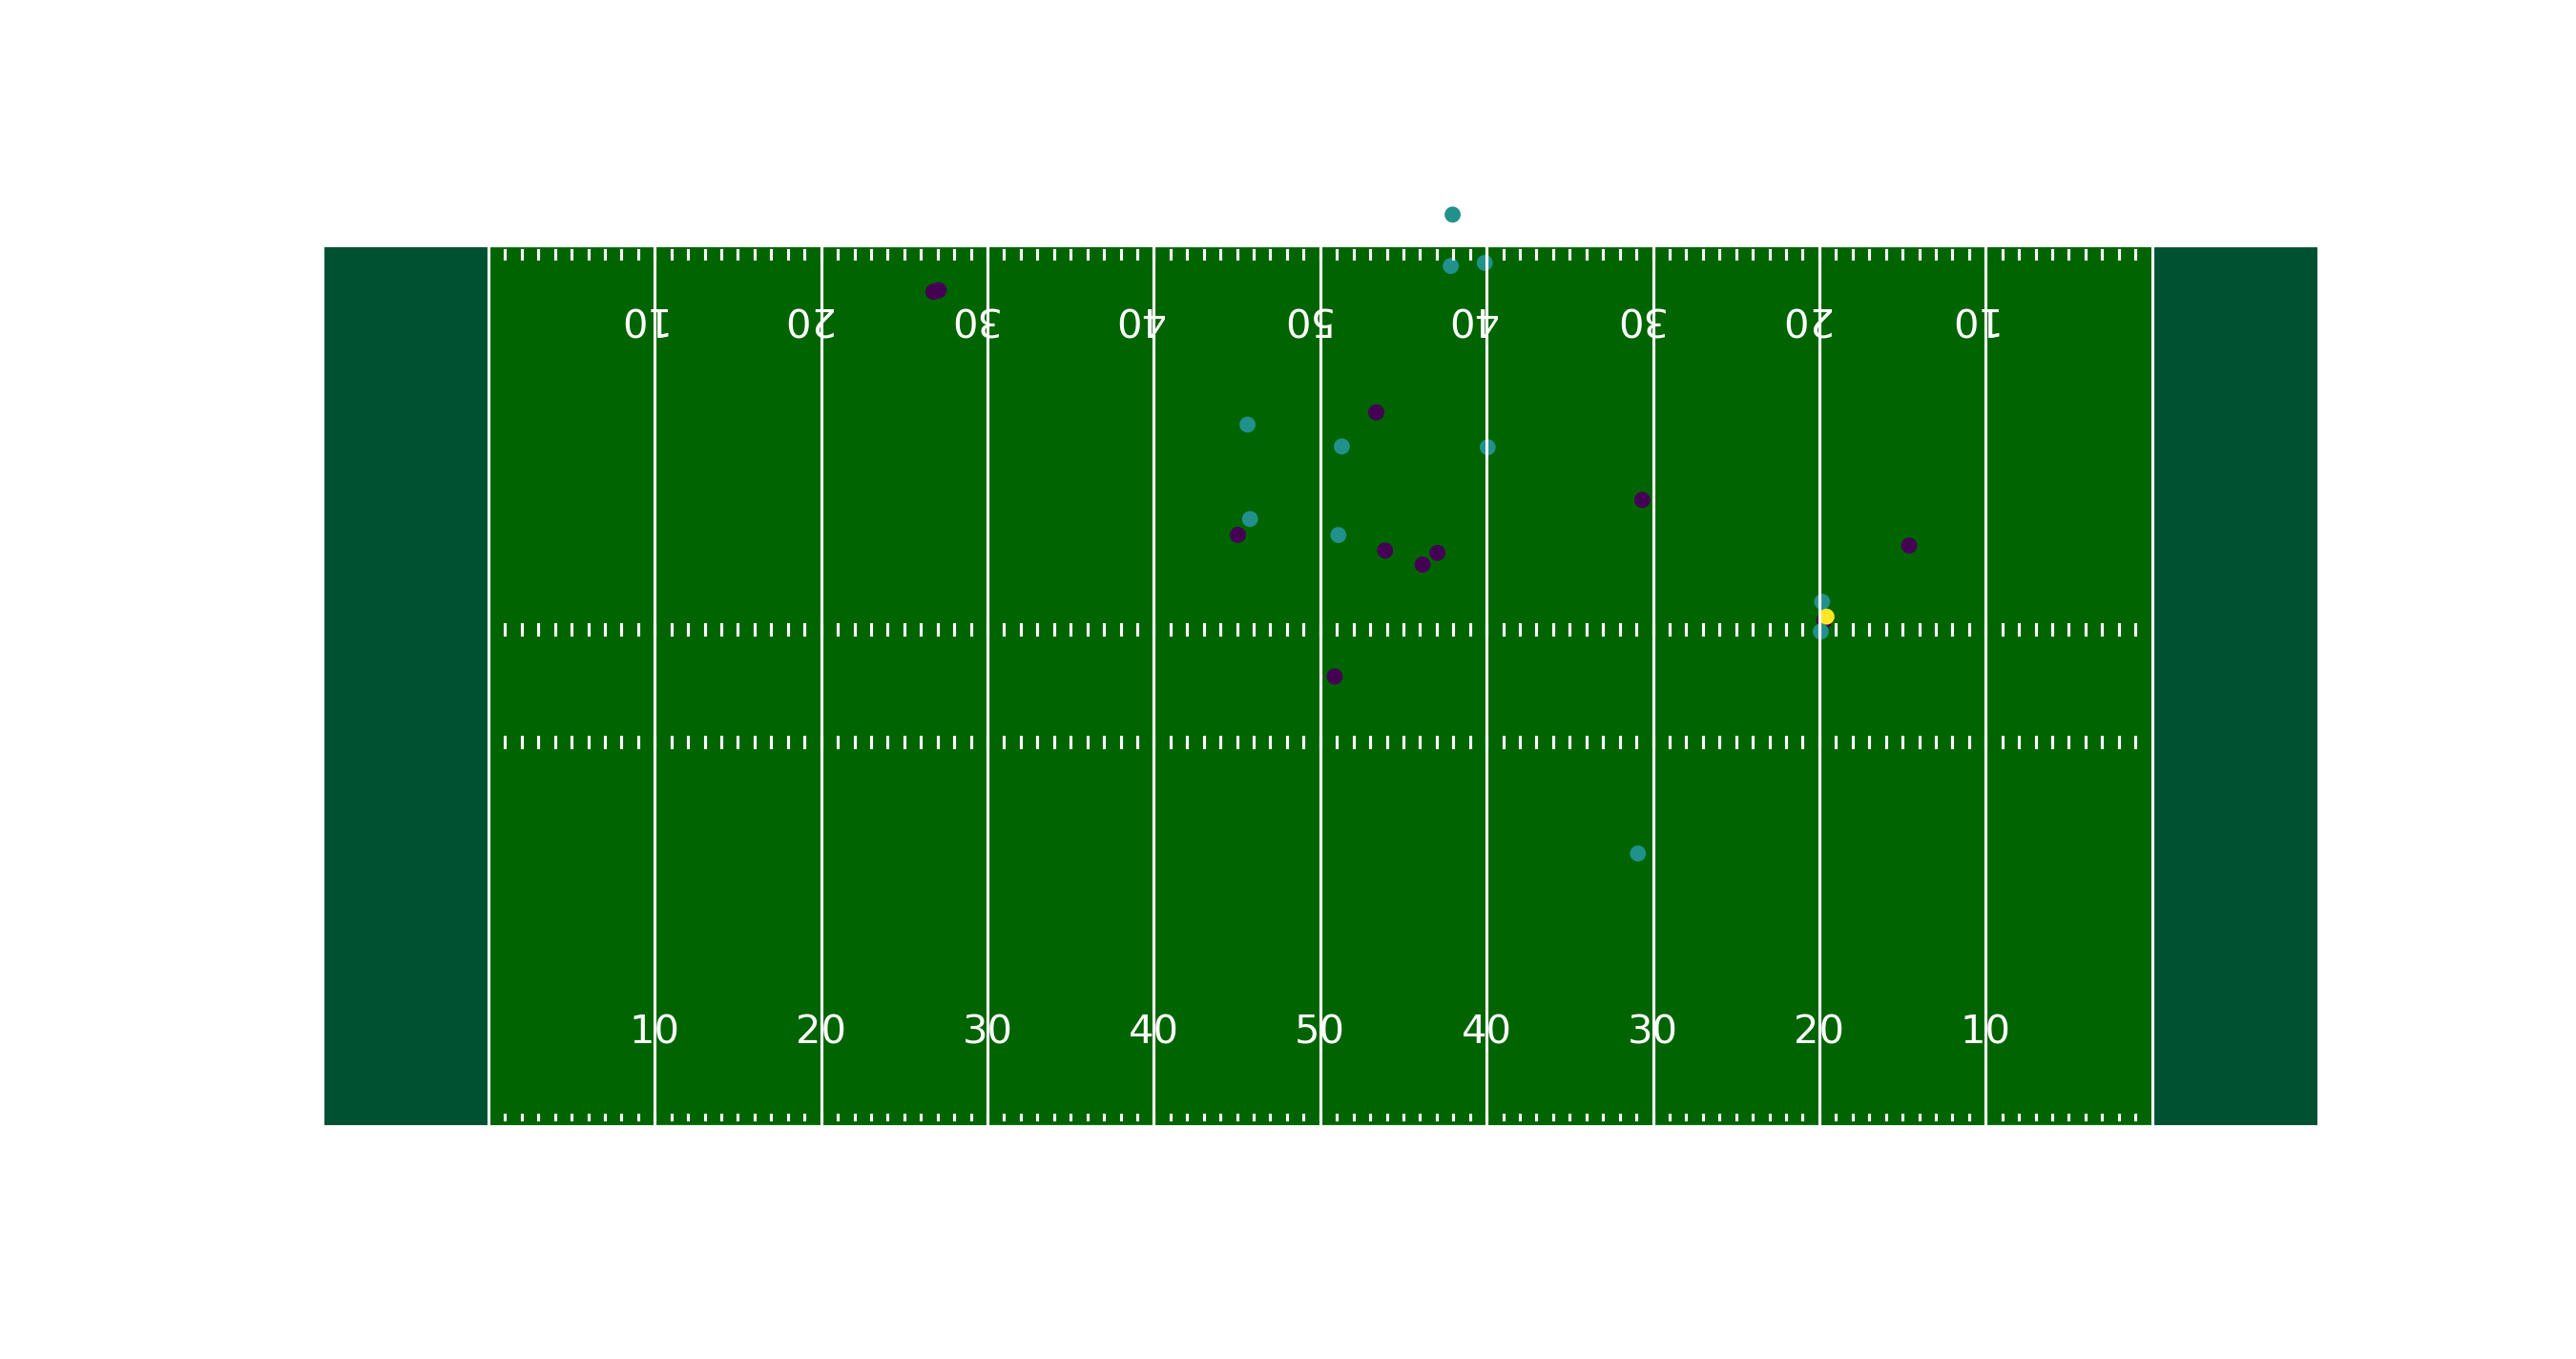

In [50]:
'''
View true play
'''

%matplotlib notebook


def update_plot(i, play_df, all_times, home_away, scat):
    
    time = all_times[i]
    time_df = play_df.query("time == @time")
    
    true_next_state = np.stack(time_df.loc[:,'state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(-1,8)
    
    data = np.zeros((23, 2))
    data[:,0] = true_next_state[:,2]
    data[:,1] = true_next_state[:,3] + 26
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

numframes = 30
numpoints = 10

play_to_viz = data_df.query("gameId == @game_id and playId == @play_id")
home_away = get_home_away(returned_plays.query("gameId == @game_id and playId == @play_id"), device)
all_times = np.unique(play_to_viz.time)

display(returned_plays.query("gameId == @game_id and playId == @play_id"))
print("number of plays = ", len(all_times))

time = all_times[0]
time_df = play_to_viz.query("time == @time")
true_next_state = np.stack(time_df.loc[:,'state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(-1,8)

fig, ax = create_football_field()
scat = ax.scatter(true_next_state[:,2],true_next_state[:,3] + 26, c=home_away, s=50)

ani = FuncAnimation(fig, update_plot, frames=numframes, fargs=(play_to_viz, all_times, home_away, scat))
plt.show()

In [ ]:
%matplotlib notebook

def update_plot(i, tensor_state_cpu, home_away, scat):
    
    data = np.zeros((23, 2))
    data[:,0] = np.array(tensor_state_cpu[i][:,2])
    data[:,1] = np.array(tensor_state_cpu[i][:,3] + 26)
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

numframes = 10
numpoints = 10

play_to_viz = returned_plays.query("gameId == @game_id and playId == @play_id")

#display(play_to_viz)

home_away = get_home_away(play_to_viz, device)
tensor_state_cpu = np.array(torch.squeeze(predicted_states,1).detach().cpu()).reshape(predicted_states.size()[0], -1, 8)

i=0

#print(tensor_state_cpu[0][1:3,:])
#print(tensor_state_cpu[i][1:3,:])

fig, ax = create_football_field()
scat = ax.scatter(tensor_state_cpu[i][:,2],tensor_state_cpu[i][:,3] + 26, c=home_away, s=50)

ani = FuncAnimation(fig, update_plot, frames=numframes, fargs=(tensor_state_cpu, home_away, scat))
plt.show()

In [25]:
def get_home_away(play, device):

    gameId = play.loc[:,'gameId'].values[0]
    playId = play.loc[:,'playId'].values[0]
    returnerId = float(play.loc[:,'returnerId'])
    season = str(gameId)[0:4]

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")

    # inspect each time
    received_time = np.unique(play_df.query("event == 'kick_received' or event == 'punt_received'").time)[0]
    tackled_time = np.unique(play_df.query("event == 'tackle'").time)[0]

    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    # iterate through the times
    all_times = list(np.unique(runner_times.time))
    time_string = all_times[0]

    time_play_df = runner_times.query("time == @time_string", inplace=False).reset_index()

    team_list = [1 if x == 'home' else 0 for x in time_play_df.team]
    home_away_arr = np.array(team_list)
    home_away_arr[-1] = 2
    
    return home_away_arr

In [23]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax